In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from rl_analysis.plotting import savefig, setup_plotting_env, clean_ticks, geno_palette
from rl_analysis.io.df import dlight_exclude_toml
from rl_analysis.photometry.snippet import get_shuffle_average
from functools import partial
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import toml

# Looking at dLight waveforms around transitions split by velocity

In [3]:
with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
import multiprocessing as mp

mp.set_start_method("spawn", force=True)

In [5]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
dlight_cfg = analysis_config["dlight_basic_analysis"]
dlight_common_cfg = analysis_config["dlight_common"]
figure_cfg = analysis_config["figures"]
renormalize = True
dask_address = None
use_area = "dms"  # dms and dls are run separately by changing this parameter
use_key = "signal_reref_dff_z_renorm" if renormalize else "signal_reref_dff_z"
pre_trim = (-90, +90)  # window to keep (in samples) after renorm

In [6]:
scalars = [
    "velocity_2d_mm",
    "velocity_angle",
    "acceleration_2d_mm",
    "velocity_height",
    "jerk_2d_mm",
]

In [7]:
load_keys = [
    "x",
    "session_number",
    "uuid",
    "signal_reref_dff_z",
    "mouse_id",
    "snippet",
    "duration",
    "area",
    "opsin",
    "target_syllable",
    "signal_max",
    "signal_reference_corr",
    "stim_duration",
    "syllable",
] + scalars

In [8]:
use_dct = dlight_exclude_toml(
    os.path.join(raw_dirs["dlight"], "dlight_photometry_processed_full.toml"),
    **analysis_config["dlight_common"]
)

use_uuids = list(use_dct.keys())

In [9]:
# use longwin for renormalization
_snippet_df = pd.read_parquet(
    os.path.join(raw_dirs["dlight"], "dlight_snippets_offline_longwin.parquet"),
    columns=load_keys,
    filters=[("area", "=", use_area), ("uuid", "in", use_uuids)],
).sort_index()
_snippet_df["init_type"] = "syllables_offline"

_snippet_df2 = pd.read_parquet(
    os.path.join(raw_dirs["dlight"], "dlight_snippets_movements_longwin.parquet"),
    columns=load_keys,
    filters=[("area", "=", use_area), ("uuid", "in", use_uuids)],
).sort_index()
_snippet_df2["init_type"] = "movement"
snippet_df = pd.concat([_snippet_df, _snippet_df2])

del _snippet_df, _snippet_df2
snippet_df = snippet_df.dropna(subset=["x", "duration"])
snippet_df.index = range(len(snippet_df))

In [10]:
snippet_df["x"] = (snippet_df["x"] * 30).round().astype("int")
snippet_df["duration"] = (snippet_df["duration"] * 30).round().astype("int")

In [11]:
scalars_z = [f"{_scalar}_z" for _scalar in scalars]

In [12]:
snippet_df[scalars_z] = snippet_df.groupby("uuid")[scalars].transform(
    lambda x: (x - x.mean()) / x.std()
)

In [13]:
snippet_df = snippet_df.groupby("uuid").filter(lambda x: x["snippet"].nunique() > 5)

In [14]:
codes = pd.factorize(
    pd._libs.lib.fast_zip(
        [snippet_df["snippet"].values, snippet_df["init_type"].values]
    )
)[0]

In [15]:
snippet_df["snippet"] = codes

In [16]:
from numba import jit


@jit(nopython=True)
def zscore_nb(values, index):
    return (values - np.nanmean(values)) / np.nanstd(values)

In [17]:
if renormalize:
    renormed_values = snippet_df.groupby("snippet")["signal_reref_dff_z"].transform(
        zscore_nb, engine="numba"
    )
    snippet_df["signal_reref_dff_z_renorm"] = renormed_values

In [18]:
snippet_df = snippet_df.loc[snippet_df["x"].between(*pre_trim, inclusive="both")].copy()

In [19]:
scalar_means = (
    snippet_df.loc[(snippet_df["x"] > 0) & (snippet_df["x"] < snippet_df["duration"])]
    .groupby("snippet")[scalars_z]
    .mean()
)

In [20]:
uuids = snippet_df.drop_duplicates("snippet").set_index("snippet")["uuid"]

In [21]:
scalar_means = scalar_means.reset_index()
scalar_means["uuid"] = scalar_means["snippet"].map(uuids).astype("str")

In [22]:
scalar_means = scalar_means.set_index("snippet")

In [23]:
scalar_diffs = scalar_means.groupby("uuid")[scalars_z].diff()
scalar_diffs = scalar_diffs.reset_index()
scalar_diffs["uuid"] = scalar_diffs["snippet"].map(uuids).astype("str")

In [24]:
scalar_bins = (
    scalar_diffs.groupby("uuid")[scalars_z]
    .transform(lambda x: pd.qcut(x, 4, labels=False))
    .astype("UInt8")
)
scalar_bins.columns = [f"{col}_bin" for col in scalar_bins.columns]
scalar_diffs[scalar_bins.columns] = scalar_bins

In [25]:
for col in tqdm(scalar_bins.columns):
    snippet_df[col] = snippet_df["snippet"].map(scalar_diffs.set_index("snippet")[col])

  0%|          | 0/5 [00:00<?, ?it/s]

In [26]:
tqdm.pandas()

In [27]:
from scipy import signal

In [28]:
soscoeffs = signal.bessel(1, 1 / (30 / 2.0), btype="high", output="sos")
filter_func = lambda x: signal.sosfiltfilt(soscoeffs, x)

In [29]:
snippet_df["signal_reref_dff_z_hp"] = snippet_df.groupby("snippet")[
    use_key
].progress_transform(filter_func)

  0%|          | 0/179166 [00:00<?, ?it/s]

In [30]:
use_feature = "signal_reref_dff_z_hp"

In [31]:
features = (
    snippet_df.loc[snippet_df["x"].between(0.0, 0.3, inclusive="both")]
    .groupby("snippet")[use_feature]
    .agg(["max"])
    # .agg(["max", "min", "mean"])
)

In [32]:
# now we're going to bin dLight in each scalar bin...

In [33]:
for col in tqdm(scalar_bins.columns):
    use_scalar_bins = scalar_diffs.set_index("snippet")[col]
    features = features.loc[features.index.intersection(use_scalar_bins.index)]
    feature_bins = features.groupby(use_scalar_bins).transform(
        lambda x: pd.qcut(x, 4, labels=False)
    )
    for _feature in tqdm(feature_bins.columns):
        snippet_df[f"{_feature}_{col}_bin"] = (
            snippet_df["snippet"].map(feature_bins[_feature]).astype("UInt8")
        )

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [34]:
for _feature in tqdm(features.columns):
    feature_bins = pd.qcut(features[_feature], 4, labels=False)
    snippet_df[f"{_feature}_bin"] = (
        snippet_df["snippet"].map(feature_bins).astype("UInt8")
    )

  0%|          | 0/1 [00:00<?, ?it/s]

In [35]:
bin_cols = snippet_df.filter(regex="bin$").columns
snippet_df = snippet_df.dropna(subset=bin_cols)
for _col in bin_cols:
    snippet_df[_col] = snippet_df[_col].astype("uint8")

In [37]:
plt_scalars = ["velocity_2d_mm_z", "jerk_2d_mm_z"]
plt_scalar_bins = [f"{_plt_scalar}_bin" for _plt_scalar in plt_scalars]
plt_dlight_bins = [f"max_{_plt_scalar}_bin_bin" for _plt_scalar in plt_scalars]

In [39]:
use_df = snippet_df[
    [
        use_feature,
        "snippet",
        "x",
        "max_bin",
        "init_type",
        "mouse_id",
    ]
    + plt_scalar_bins
    + plt_dlight_bins
].copy()
groupby_arrays = [snippet_df["init_type"].values]
use_df.index = range(len(use_df))

## Randomization with peak value bins

In [40]:
signal_key = use_feature
lags = (
    snippet_df.groupby(["x", "init_type"])[signal_key]
    .mean()
    .groupby("init_type")
    .apply(lambda x: x.idxmin()[0])
)

In [41]:
nshuffles = 100

In [42]:
snippet_lst = snippet_df["snippet"].unique()
shuffle_quantity = pd.Series(use_df["snippet"].unique()).rename("snippet")

In [43]:
dlight_bin = ["x", "init_type", "mouse_id"]

In [44]:
all_xlims = (-1.5 * 30, 1.5 * 30)
shuffle_xlims = (-90, +90)
n_jobs = 30

In [45]:
func = partial(
    get_shuffle_average,
    use_df=use_df[dlight_bin + [use_feature, "snippet"]].loc[
        use_df["x"].between(*all_xlims, inclusive="both")
    ],
    shuffle_quantity=shuffle_quantity,
    shuffle_x=False,
    dlight_bin=dlight_bin,
)

In [46]:
delays = [delayed(func)(sidx) for sidx in range(nshuffles)]
results = Parallel(n_jobs=n_jobs, verbose=10, backend="multiprocessing")(delays)

[Parallel(n_jobs=30)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=30)]: Done  12 tasks      | elapsed:   11.5s
[Parallel(n_jobs=30)]: Done  25 tasks      | elapsed:   20.7s
[Parallel(n_jobs=30)]: Done  38 tasks      | elapsed:   28.6s
[Parallel(n_jobs=30)]: Done  52 out of 100 | elapsed:   35.1s remaining:   32.4s
[Parallel(n_jobs=30)]: Done  63 out of 100 | elapsed:   40.8s remaining:   24.0s
[Parallel(n_jobs=30)]: Done  74 out of 100 | elapsed:   46.5s remaining:   16.4s
[Parallel(n_jobs=30)]: Done  85 out of 100 | elapsed:   52.2s remaining:    9.2s
[Parallel(n_jobs=30)]: Done  96 out of 100 | elapsed:   57.9s remaining:    2.4s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:   60.0s finished


In [47]:
observed_ave_df = pd.concat(results, axis=0)

In [48]:
func = partial(
    get_shuffle_average,
    use_df=use_df[dlight_bin + [use_feature, "snippet"]].loc[
        use_df["x"].between(*shuffle_xlims, inclusive="both")
    ],
    shuffle_quantity=None,
    shuffle_x=True,
    dlight_bin=dlight_bin,
)

In [49]:
delays = [delayed(func)(sidx) for sidx in range(nshuffles)]
results = Parallel(n_jobs=n_jobs, verbose=10, backend="multiprocessing")(delays)

[Parallel(n_jobs=30)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   1 tasks      | elapsed:   28.6s
[Parallel(n_jobs=30)]: Done  12 tasks      | elapsed:   44.6s
[Parallel(n_jobs=30)]: Done  25 tasks      | elapsed:  1.0min
[Parallel(n_jobs=30)]: Done  38 tasks      | elapsed:  1.3min
[Parallel(n_jobs=30)]: Done  52 out of 100 | elapsed:  1.6min remaining:  1.5min
[Parallel(n_jobs=30)]: Done  63 out of 100 | elapsed:  1.8min remaining:  1.1min
[Parallel(n_jobs=30)]: Done  74 out of 100 | elapsed:  2.1min remaining:   45.3s
[Parallel(n_jobs=30)]: Done  85 out of 100 | elapsed:  2.3min remaining:   23.8s
[Parallel(n_jobs=30)]: Done  96 out of 100 | elapsed:  2.5min remaining:    6.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:  2.5min finished


In [50]:
shuffle_ci_ave_df = pd.concat(results, axis=0)

In [51]:
func = partial(
    get_shuffle_average,
    use_df=use_df[dlight_bin + [use_feature, "snippet"]].loc[
        use_df["x"].between(*all_xlims, inclusive="both")
    ],
    shuffle_quantity=None,
    shuffle_x=True,
    dlight_bin=dlight_bin,
)

In [52]:
delays = [delayed(func)(sidx) for sidx in range(nshuffles)]
results = Parallel(n_jobs=n_jobs, verbose=10, backend="multiprocessing")(delays)

[Parallel(n_jobs=30)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   1 tasks      | elapsed:   23.4s
[Parallel(n_jobs=30)]: Done  12 tasks      | elapsed:   31.9s
[Parallel(n_jobs=30)]: Done  25 tasks      | elapsed:   43.4s
[Parallel(n_jobs=30)]: Done  38 tasks      | elapsed:   54.4s
[Parallel(n_jobs=30)]: Done  52 out of 100 | elapsed:  1.1min remaining:  1.0min
[Parallel(n_jobs=30)]: Done  63 out of 100 | elapsed:  1.2min remaining:   42.5s
[Parallel(n_jobs=30)]: Done  74 out of 100 | elapsed:  1.4min remaining:   29.7s
[Parallel(n_jobs=30)]: Done  85 out of 100 | elapsed:  1.6min remaining:   16.4s
[Parallel(n_jobs=30)]: Done  96 out of 100 | elapsed:  1.7min remaining:    4.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:  1.7min finished


In [53]:
shuffle_grand_ave_df = pd.concat(results, axis=0)

In [54]:
group_keys = ["x", "init_type", "mouse_id"]
# shuffle_group_keys = ["init_type","mouse_id"]
shuffle_group_keys = group_keys
observed_mean = use_df.groupby(group_keys)[signal_key].mean()
shuffle_group_keys = group_keys
shuffle_agg = shuffle_ci_ave_df.groupby(shuffle_group_keys + ["idx"]).mean()
shuffle_mu = shuffle_agg.groupby(shuffle_group_keys)[signal_key].mean()
shuffle_sig = shuffle_agg.groupby(shuffle_group_keys)[signal_key].std()

In [56]:
shuffle_ave_ci = shuffle_agg.groupby(["init_type", "idx"]).mean()

In [57]:
shuffle_group_keys

['x', 'init_type', 'mouse_id']

In [58]:
_test = (
    shuffle_grand_ave_df.groupby(shuffle_group_keys + ["idx"])[signal_key].mean()
    - shuffle_mu
) / shuffle_sig
_test = _test.dropna()
shuffle_cis = _test.groupby("init_type").quantile([0.025, 0.975])
shuffle_cis.index = shuffle_cis.index.set_names("ci", level=-1)

In [59]:
lims = shuffle_cis.groupby(["init_type", "ci"]).mean()
lims = lims.groupby("ci").apply(lambda x: x.values[np.argmax(x.values)])

In [60]:
observed_z = (observed_mean - shuffle_mu) / shuffle_sig
observed_z = observed_z.reset_index()
observed_z["x"] /= 30.0

In [61]:
observed_zs_all = (
    observed_ave_df.groupby(group_keys + ["idx"]).mean()[signal_key] - shuffle_mu
) / shuffle_sig
observed_zs_all = (
    observed_zs_all.reset_index().set_index(group_keys + ["idx"]).sort_index()
)
observed_zs_average = observed_zs_all.groupby(["x", "init_type", "idx"]).mean()

In [63]:
vals = (
    observed_zs_all.loc[-30:30]
    .groupby(["init_type", "mouse_id"])
    .apply(lambda x: x.abs().mean())
    .dropna()
)

In [66]:
from scipy.stats import wilcoxon

In [67]:
use_test = wilcoxon

In [68]:
stats = {}
stats["movement-syllables_offline"] = {}
stats["movement-syllables_offline"]["test"] = str(use_test.__name__)

In [69]:
stat, p = use_test(
    vals.loc["movement"][signal_key].values,
    vals.loc["syllables_offline"][signal_key].values,
)

In [70]:
stats["movement-syllables_offline"]["stat"] = stat
stats["movement-syllables_offline"]["p"] = p
stats["movement-syllables_offline"]["n1"] = len(vals.loc["movement"])
stats["movement-syllables_offline"]["n2"] = len(vals.loc["syllables_offline"])
stats["movement-syllables_offline"]["n_definition"] = "nmice"

In [71]:
stats["movement-syllables_offline"]["n_snippets_movement"] = snippet_df[
    "snippet"
].nunique()

In [72]:
stats

{'movement-syllables_offline': {'test': 'wilcoxon',
  'stat': 0.0,
  'p': 0.0078125,
  'n1': 8,
  'n2': 8,
  'n_definition': 'nmice',
  'n_snippets_movement': 171284}}

In [73]:
with open(
    os.path.join(
        proc_dirs["dlight"], f"stats_movement_init_{use_area}_renorm-{renormalize}.toml"
    ),
    "w",
) as f:
    toml.dump(stats, f)

In [74]:
setup_plotting_env()
# sns.set_context("paper")

In [75]:
observed_cis = (
    (
        (observed_ave_df.groupby(group_keys + ["idx"])[signal_key].mean() - shuffle_mu)
        / shuffle_sig
    )
    .groupby(group_keys)
    .quantile([0.025, 0.975])
).dropna()
observed_cis.index = observed_cis.index.set_names("ci", level=-1)
observed_cis = observed_cis.groupby(["x", "init_type", "ci"]).mean()

In [76]:
observed_z = observed_zs_average.groupby(["x", "init_type"]).mean()

In [77]:
# colors = sns.color_palette()[:2]
colors = [sns.color_palette()[1], geno_palette.snc]

In [78]:
plt_types = ["movement", "syllables_offline"]

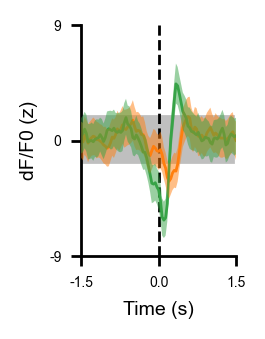

In [79]:
fig, ax = plt.subplots(1, figsize=(1, 1.5))

for _type, _color in zip(plt_types, colors):
    obs_lo = observed_cis.xs(_type, level="init_type").iloc[::2]
    obs_hi = observed_cis.xs(_type, level="init_type").iloc[1::2]
    plt_xvec = obs_lo.index.get_level_values("x") / 30.0
    # ax.plot(xvec, obs_lo.values)
    ax.fill_between(
        plt_xvec,
        obs_lo.values,
        obs_hi.values,
        fc=_color,
        alpha=0.5,
        zorder=100,
        lw=0,
        ec="none",
    )
    ax.plot(
        plt_xvec, observed_z.xs(_type, level="init_type").values, color=_color, lw=1
    )

    ax.set_xlim(-1.5, 1.5)
    # ax.set_ylim(-13, 13)

clean_ticks(ax, "y", include_zero=True, zero_symmetry=True, precision=0, dtype=int)
clean_ticks(ax, "x", precision=1, dtype=float)
# ax.axhline(y=0, color=plt.rcParams["axes.edgecolor"], zorder=-150)
ax.axvline(x=0, color=plt.rcParams["axes.edgecolor"], zorder=-150, alpha=1, ls="--")
xlims = ax.get_xlim()
ax.fill_between(
    ax.get_xlim(), lims.values[0], lims.values[1], fc=[0.75] * 3, alpha=1, zorder=-200
)
plt.ylabel("dF/F0 (z)")
plt.xlabel("Time (s)")
# plt.axvline(x=.075, ls="-.")
sns.despine()
plt.show()
savefig(
    fig,
    os.path.join(
        figure_cfg["store_dir"],
        f"dlight_initiation_grand_average_quartiles_merged_{use_area}_renorm-{renormalize}",
    ),
    bbox_inches="tight",
)
# _ax.axvline(x=0, color="k", zorder=-100, alpha=0.5)

In [80]:
use_group_keys = list(set(group_keys).union(set(["mouse_id", "idx"])))

In [81]:
observed_zs_all_store = (
    observed_ave_df.groupby(use_group_keys).mean()[signal_key] - shuffle_mu
) / shuffle_sig
observed_zs_all_store = observed_zs_all_store.dropna()
observed_zs_all_store.reset_index().to_parquet(
    os.path.join(
        proc_dirs["dlight"],
        f"snippet_max_bin_ave_zscored_{use_area}_renorm-{renormalize}.parquet",
    )
)

## Randomization w/r/t scalar values

0it [00:00, ?it/s]

[Parallel(n_jobs=30)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   1 tasks      | elapsed:   29.3s
[Parallel(n_jobs=30)]: Done  12 tasks      | elapsed:   44.4s
[Parallel(n_jobs=30)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=30)]: Done  38 tasks      | elapsed:  1.4min
[Parallel(n_jobs=30)]: Done  52 out of 100 | elapsed:  1.6min remaining:  1.5min
[Parallel(n_jobs=30)]: Done  63 out of 100 | elapsed:  1.8min remaining:  1.1min
[Parallel(n_jobs=30)]: Done  74 out of 100 | elapsed:  2.1min remaining:   44.8s
[Parallel(n_jobs=30)]: Done  85 out of 100 | elapsed:  2.3min remaining:   24.1s
[Parallel(n_jobs=30)]: Done  96 out of 100 | elapsed:  2.5min remaining:    6.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:  2.5min finished
/home/markowitzmeister_gmail_com/miniconda3/envs/spont-da/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for t

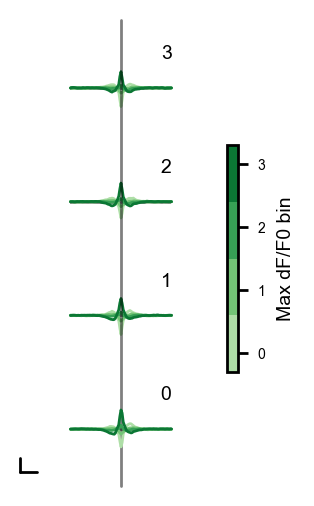

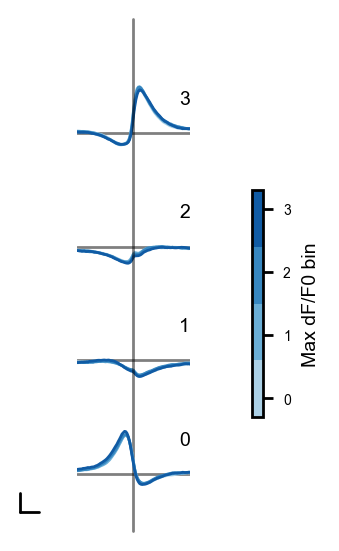

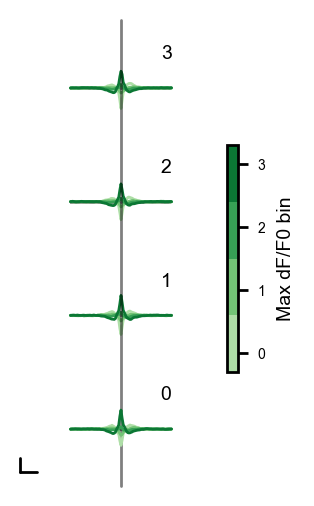

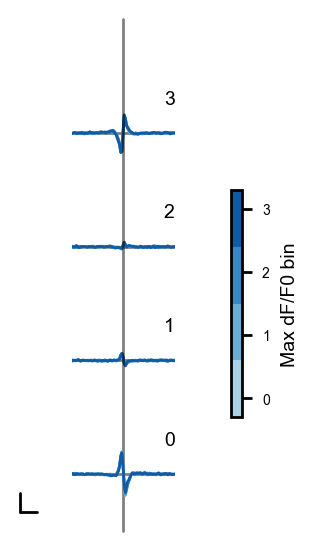

In [82]:
for (_plt_scalar_bin, _plt_dlight_bin, _plt_scalar) in tqdm(
    zip(plt_scalar_bins, plt_dlight_bins, plt_scalars)
):
    snippet_lst = snippet_df["snippet"].unique()
    shuffle_quantity = pd.Series(use_df["snippet"].unique()).rename("snippet")

    func = partial(
        get_shuffle_average,
        use_df=use_df[
            [_plt_scalar_bin, _plt_dlight_bin, use_feature, "x", "init_type", "snippet"]
        ],
        shuffle_quantity=None,
        shuffle_x=True,
        dlight_bin=["x", "init_type", _plt_scalar_bin, _plt_dlight_bin],
    )

    delays = [delayed(func)(sidx) for sidx in range(nshuffles)]
    results = Parallel(n_jobs=n_jobs, verbose=10, backend="multiprocessing")(delays)

    shuffle_grand_ave_df = pd.concat(results, axis=0)

    group_keys = ["x", "init_type", _plt_dlight_bin, _plt_scalar_bin]
    signal_key = use_feature
    observed_mean = snippet_df.groupby(group_keys)[signal_key].mean()
    shuffle_mu = shuffle_grand_ave_df.groupby(group_keys)[signal_key].mean()
    shuffle_sig = shuffle_grand_ave_df.groupby(group_keys)[signal_key].std()

    shuffle_grand_ave_df = shuffle_grand_ave_df.reset_index()

    _test = (
        shuffle_grand_ave_df.set_index(group_keys)[signal_key] - shuffle_mu
    ) / shuffle_sig
    shuffle_cis = _test.groupby(group_keys).quantile([0.025, 0.975])
    shuffle_cis.index = shuffle_cis.index.set_names("ci", level=-1)

    lims = shuffle_cis.groupby("ci").mean().values

    observed_z = (observed_mean - shuffle_mu) / shuffle_sig

    observed_z = observed_z.reset_index()
    observed_z["x"] /= 30.0

    # observed_zs = (observed_ave_df.set_index("idx", append=True)[signal_key] - shuffle_mu) / shuffle_sig
    # observed_zs = observed_zs.groupby(["x","init_type","idx"]).mean()

    show_scalar_bins = observed_z[_plt_scalar_bin].dropna().sort_values().unique()

    pal = sns.color_palette("Greens", n_colors=len(show_scalar_bins) + 1)[1:]
    cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list(
        "",
        pal,
        len(show_scalar_bins),
    )

    sm = plt.matplotlib.cm.ScalarMappable(
        cmap=cmap, norm=plt.Normalize(vmin=-0.1, vmax=1.1)
    )
    sm.set_array([])
    # Remove the legend and add a colorbar

    setup_plotting_env()

    g = sns.relplot(
        data=observed_z.loc[
            (observed_z["init_type"] == "syllables_offline")
            & (observed_z["x"].between(-1.5, 1.5, inclusive="both"))
        ].reset_index(),
        x="x",
        y=signal_key,
        # y="signal_reref_dff_z",
        row=_plt_scalar_bin,
        row_order=reversed(show_scalar_bins),
        hue=_plt_dlight_bin,
        ci=None,
        height=0.7,
        aspect=2.25,
        n_boot=0,
        kind="line",
        legend=False,
        palette=cmap,
        lw=1,
        clip_on=False,
    )
    g.fig.set_size_inches(1.5, 3)
    g.set_titles(row_template="{row_name}")
    g.set(xlim=(-1.5, 1.5), ylim=(-400, 400))
    yscale = 100
    yloc = -300
    xscale = 0.5
    xloc = -3

    for _ax in g.axes.flat:
        #     pass
        title = _ax.get_title()
        _ax.set_title("")
        _ax.set_title(title, loc="right", y=1, pad=-10)
        _ax.axis("off")
        # _ax.axvline(x=0, color="k", zorder=-300, alpha=0.5)
        _ax.axhline(y=0, color="k", zorder=-300, alpha=0.5)

    ylims = _ax.get_ylim()

    total_span = (ylims[1] - ylims[0]) * len(g.axes.flat)
    _ax.plot(
        [0, 0],
        [ylims[0], total_span * 0.9],
        color="k",
        zorder=-200,
        clip_on=False,
        alpha=0.5,
    )
    _ax.set_ylim(ylims)
    g.axes.flat[-1].plot([xloc, xloc], [yloc, yloc + yscale], color="k", clip_on=False)
    g.axes.flat[-1].plot([xloc, xloc + xscale], [yloc, yloc], color="k", clip_on=False)

    g.fig.subplots_adjust(hspace=0)
    cb = g.fig.colorbar(
        sm,
        ax=g.axes.ravel().tolist(),
        pad=0.3,
        label="Max dF/F0 bin",
        shrink=0.5,
        ticks=np.linspace(0, 1, len(show_scalar_bins)),
    )
    cb.set_ticklabels(show_scalar_bins)
    savefig(
        g.fig,
        os.path.join(
            figure_cfg["store_dir"],
            f"dlight_speed_transition_bins_max_split_shufflez_{_plt_scalar}_{use_area}_renorm-{renormalize}",
        ),
        bbox_inches="tight",
    )

    observed_scalar_mean = (
        snippet_df.groupby(group_keys)[_plt_scalar].mean()
        # .xs("syllable_offline", level="init_type")
        .reset_index()
    )

    pal = sns.color_palette("Blues", n_colors=len(show_scalar_bins) + 1)[1:]
    cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list(
        "",
        pal,
        len(show_scalar_bins),
    )

    sm = plt.matplotlib.cm.ScalarMappable(
        cmap=cmap, norm=plt.Normalize(vmin=-0.1, vmax=1.1)
    )
    sm.set_array([])
    # Remove the legend and add a colorbar

    observed_scalar_mean["x"] /= 30.0
    g = sns.relplot(
        data=observed_scalar_mean.loc[
            (observed_scalar_mean["init_type"] == "syllables_offline")
            & (observed_scalar_mean["x"].between(-1.5, 1.5, inclusive="both"))
        ],
        x="x",
        y=_plt_scalar,
        row=_plt_scalar_bin,
        row_order=reversed(show_scalar_bins),
        hue=_plt_dlight_bin,
        ci=None,
        height=0.7,
        aspect=2.25,
        n_boot=0,
        kind="line",
        legend=False,
        palette=cmap,
        lw=1,
        facet_kws={"sharey": True, "sharex": True},
    )
    g.set_titles(row_template="{row_name}")
    g.fig.set_size_inches(1.5, 3)

    yscale = 0.5
    yloc = -1
    xscale = 0.5
    xloc = -3

    for _ax in g.axes.flat:
        #     pass
        title = _ax.get_title()
        _ax.set_title("")
        _ax.set_title(title, loc="right", y=1, pad=-10)
        _ax.axis("off")
        # _ax.axvline(x=0, color="k", zorder=-300, alpha=0.5)
        _ax.axhline(y=0, color="k", zorder=-300, alpha=0.5)

    g.set(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))
    ylims = _ax.get_ylim()

    yrange = ylims[1] - ylims[0]
    _ax.plot(
        [0, 0], [ylims[0], yrange * 4], color="k", zorder=-200, clip_on=False, alpha=0.5
    )
    _ax.set_ylim(ylims)

    g.axes.flat[-1].plot([xloc, xloc], [yloc, yloc + yscale], color="k", clip_on=False)
    g.axes.flat[-1].plot([xloc, xloc + xscale], [yloc, yloc], color="k", clip_on=False)

    g.fig.subplots_adjust(hspace=0)
    cb = g.fig.colorbar(
        sm,
        ax=g.axes.ravel().tolist(),
        pad=0.3,
        label="Max dF/F0 bin",
        shrink=0.5,
        ticks=np.linspace(0, 1, len(show_scalar_bins)),
    )
    cb.set_ticklabels(show_scalar_bins)
    savefig(
        g.fig,
        os.path.join(
            figure_cfg["store_dir"],
            f"dlight_speed_transition_bins_max_split_{_plt_scalar}_{use_area}_renorm-{renormalize}",
        ),
        bbox_inches="tight",
    )